In [1]:
from imblearn.over_sampling import ADASYN

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import LOM
from sklearn.cross_validation import train_test_split
from sklearn import metrics

In [27]:
fname = "synthetic_control.data"
content = [line.strip() for line in open(fname)]
data = []
for c in content:
    data.append(np.array(c.split(' ')))
    newData = []
lens = []
for d in data:
    a = []
    for i,j in enumerate(d):
        if d[i] != '':
            a.append(float(d[i]))
    newData.append(a)
data = pd.DataFrame(newData)

In [22]:
converted = data.transpose()
normalized = (converted - converted.mean())/(converted.max() - converted.min())
normalizedData = normalized.transpose()

### Experiment 1:
 - Classify single time series 
 - We try to classify one time series as one vs all 

In [28]:
def getClassification(k = 'IT'):
    classifier = {
        'N': 100,
        'C': 200,
        'IT':300,
        'DT':400,
        'US':500,
        'DS':600
    }
    A = np.ones(600)*-1
    A[classifier[k]-100:classifier[k]] = 1
    return A

### Try to find increasing Trend

In [29]:
#data = normalizedData
data['Result'] = getClassification()
data = data.sample(frac=1)

In [30]:
from sklearn.cross_validation import train_test_split
Y_train, Y_test, L_train, L_test = train_test_split(data[data.columns[0:60]], data['Result'], test_size=0.4, random_state=0)

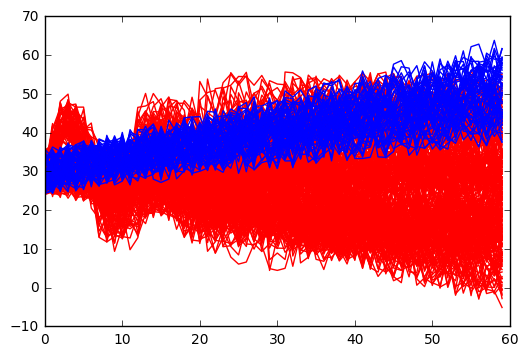

In [33]:
%matplotlib inline
def plotLabel(YBar,L,S):
    for s in range(S):
        if L[s] < 0:
            plt.plot(YBar[s].T,c='r')
    for s in range(S):
        if L[s] > 0:
            plt.plot(YBar[s].T,c='b')
#Y=5*Y
plotLabel(Y_train.as_matrix(),L_train.as_matrix(),S=Y_train.shape[0])

In [34]:
import pickle
f = open("Y_train.pickle","wb")
pickle.dump(Y_train.as_matrix(),f)
f.close()
f = open("L_train.pickle","wb")
pickle.dump(L_train.as_matrix(),f)
f.close()
f = open("Y_test.pickle","wb")
pickle.dump(Y_test.as_matrix(),f)
f.close()
f = open("L_test.pickle","wb")
pickle.dump(L_test.as_matrix(),f)
f.close()
f = open("synthetic_data.pickle","wb")
pickle.dump(data,f)
f.close()

In [8]:
C = 1
N = 60
S = Y_train.shape[0]
myModel = LOM.LOM(Y=Y_train.as_matrix(),L=L_train.values,N=N,C=1,S=S)
myModel.fit(n=60,P=3,iters=200,kernels=[],ls=3)
#result = myModel.predict(Ytest=Y_test.values) 
result,lHat,_ = myModel.predict(Ytest=Y_test.values) 
metrics.f1_score(y_pred=result,y_true=L_test.values)

Concatenated Latent Gaussian Processes:
(180, 180) (180, 180) 0 20 40 60 80 100 120 140 160 180

 /home/sudhanshu/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:F-score is ill-defined and being set to 0.0 due to no predicted samples.


0.0

(array([  2.,   1.,   1.,   8.,  98.,  56.,   8.,   2.,   2.,   2.]),
 array([-0.56167953, -0.44749723, -0.33331493, -0.21913263, -0.10495033,
         0.00923197,  0.12341427,  0.23759657,  0.35177887,  0.46596117,
         0.58014347]),
 <a list of 10 Patch objects>)

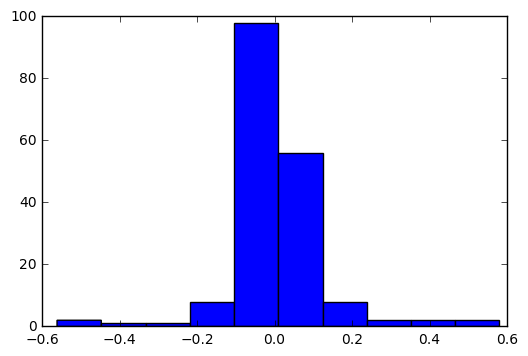

In [17]:
plt.hist(myModel.WHatExp.T)

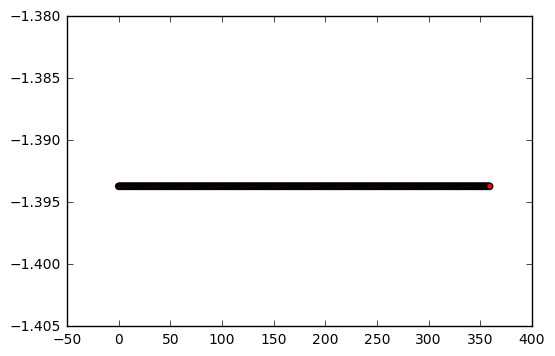

In [14]:
def getColor(L):
    if L == 'IT':
        return 'b'
    else:
        return 'r'
    
plt.scatter(range(lHat.shape[0]),lHat,c=[getColor(l) for l in L_train.values])
        

## It overfits to the negative examples due to high imbalance, we try to cure imbalance by oversampling the positive class

In [11]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
Y_resampled, L_resampled = smote.fit_sample(Y_train, L_train)
myModel = LOM.LOM(Y=Y_resampled,L=L_resampled,N=N,C=1,S=Y_resampled.shape[0])
myModel.fit(n=60,P=4,iters=200,kernels=[],ls=3)
result = myModel.predict(Ytest=Y_test.values) 
metrics.f1_score(y_pred=result[0],y_true=L_test.values)

Concatenated Latent Gaussian Processes:
(240, 240) (240, 240) 0 20 40 60 80 100 120 140 160 180

0.0

In [25]:
result = myModel.predict(Ytest=Y_train.values)

In [27]:
metrics.accuracy_score(y_pred=result[0],y_true=L_train.values)

0.84722222222222221

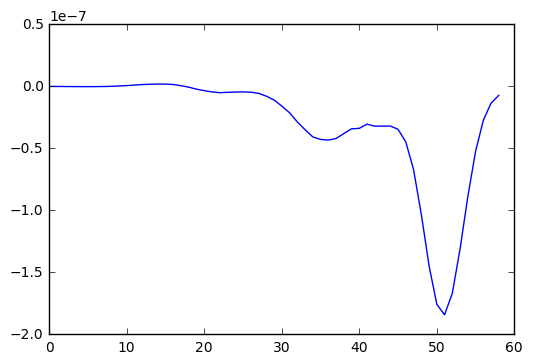

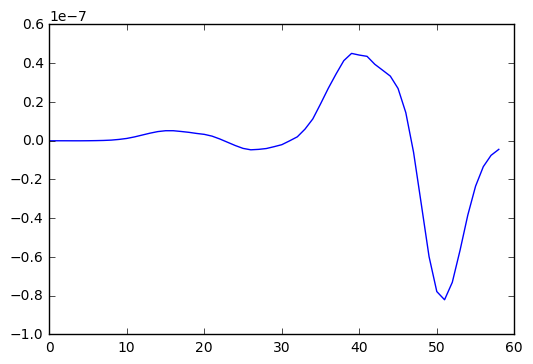

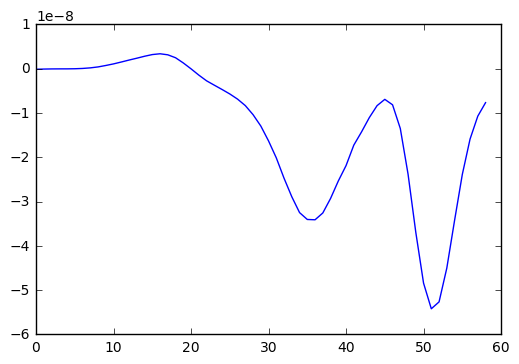

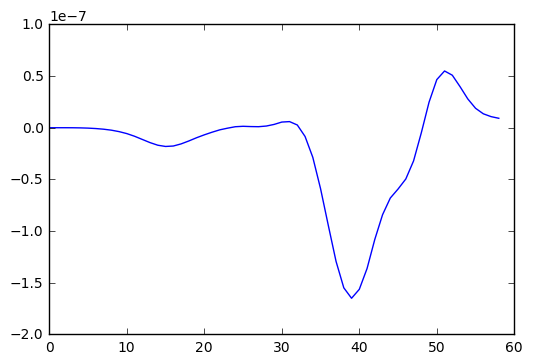

In [24]:
for p in range(myModel.P):
    plt.plot(infer[0,p*N:p*N+N-1].T)
    plt.show()

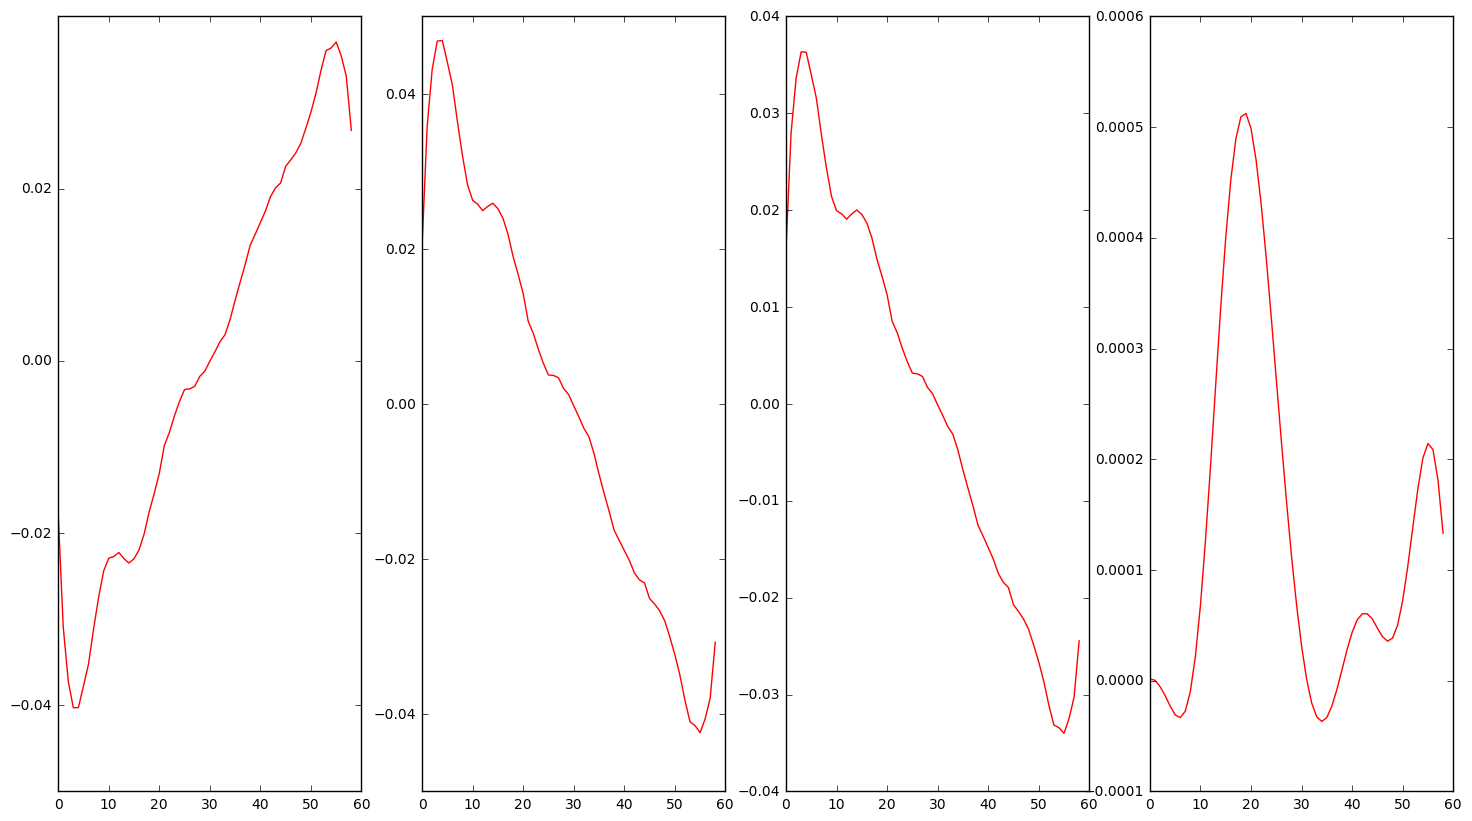

In [22]:
fig,axes = plt.subplots(nrows=1,ncols=myModel.P,figsize=(18,10))
for p in range(myModel.P):
    axes[p].plot(myModel.uExpBar[0,p*N:p*N+N-1].T,c='r')

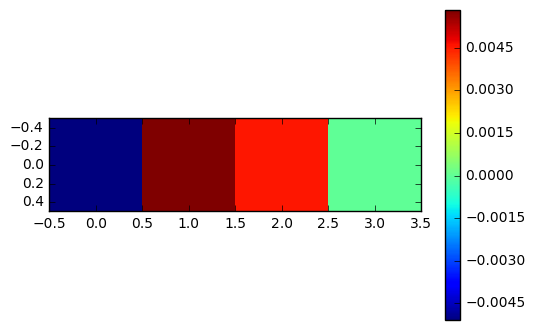

In [23]:
plt.imshow(myModel.phiHatExp,interpolation="none")
plt.colorbar()

In [28]:
## Linear increasing kernel
import GPy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
kenrel = GPy.kern.Linear(1,variances=3)  
kenrel = GPy.kern.Linear(1,variances=3) * GPy.kern.Matern52(1,variance=2,lengthscale=3) 
Matern1 = GPy.kern.PeriodicMatern32(1,lengthscale=3,variance=2)
Cosine1 = GPy.kern.Cosine(1,lengthscale=3,variance=2)
gaussian = GPy.kern.ExpQuad(1,lengthscale=3,variance=2)

In [34]:
def scale(d):
    return (d - d.min())/(d.max() - d.min())

def generatelatent(N,noiselevel=0.5):
    x = np.linspace(0,N-1,N)
    u1 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=kenrel.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    u2 = np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=gaussian.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    g1 = np.random.multivariate_normal(mean=np.ones(N).flatten(),cov=Matern1.K(x.reshape(N,1))) + noiselevel* np.random.normal(0,1,N)
    g2 = np.random.multivariate_normal(mean=np.ones(N).flatten(),cov=Cosine1.K(x.reshape(N,1))) + noiselevel*np.random.normal(0,1,N)
    return scale(u1),scale(u2),scale(g1),scale(g2)

def generateData(W,phi,latents,S=100,C=3,P=2,N=100):
    #phi = np.random.normal(loc=0,scale=1,size=(C,P))
    P = len(latents) -1
    phiBar = np.matrix(np.kron(phi,np.eye(N)))
    B = np.ones(S)
    #W = np.random.rand(P*N)
    uBar = np.matrix(np.ones((S,N*P)))
    l = np.zeros(S)
    L = np.zeros(S)
    for s in range(S):
        if np.random.rand() < 0.4:
            L[s] = 1
            us = np.hstack([a for i,a in enumerate(latents) if i!=1 ])
        else:
            L[s] = -1
            us = np.hstack([a for i,a in enumerate(latents) if i!=0 ])
        uBar[s,:] = us
        l[s] = np.dot(uBar[s,:] ,W) + B[s]
        #L[s] = guessLabel(l[s])
    #print S,C,P,N
    #print "\n--",uBar.shape,phiBar.shape
    YBar = uBar * phiBar.T + np.random.normal(0,1)
    #print YBar.shape
    return YBar,L,uBar

In [37]:
actualP=3
S=200
N = 60
latents = generatelatent(N)
W = np.random.rand(actualP*N)
phi = np.random.normal(loc=0,scale=1,size=(C,actualP))
YBar,L,_ = generateData(W,phi,latents=latents,C=C,N=N,P=actualP,S=S)

 /home/sudhanshu/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning:covariance is not positive-semidefinite.
 /home/sudhanshu/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning:covariance is not positive-semidefinite.


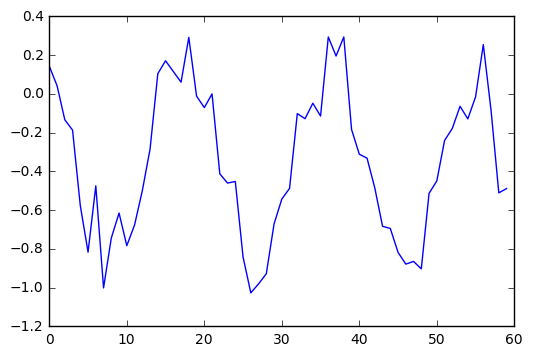

In [39]:
plt.plot(YBar[0].T)